### House price model
----------------------------

####  Import libraries and load the dataset:


In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sqlalchemy import create_engine

# Display references
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Edit pandas display option to show more rows and columns:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Query the database to extract dataset:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

# Dispose the connection, as we're only doing a single query:
engine.dispose()

# Print out the head of the dataset:
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


#### Feature engineering:

In [3]:
# Convert categorical variables to dummy variables:
houseprices_df['centralair'] = pd.get_dummies(houseprices_df['centralair'], drop_first=True)

# Convert 'mzoning' to dummy variables:
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df['mszoning'], prefix='mszoning', drop_first=True)], axis=1)

houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,0,0,1,0
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,0,0,1,0
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,0,1,0
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,0,0,1,0
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,0,0,1,0


#### Build a OLS regression model to predict house saleprice:

In [4]:
# Include the feature interactions to our model:
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']
houseprices_df['int_over_sf'] = houseprices_df['totalsf'] * houseprices_df['overallqual']

# Define the target variable and the explanatory variables:
Y = houseprices_df['saleprice']
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'int_over_sf', 'overallcond', 'mszoning_FV', 'mszoning_RL']]

# Split the dataset into training set and testing set:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print('The number of observations in the training set is {}'.format(X_train.shape[0]))
print('The number of observations in the test set is {}'.format(X_test.shape[0]))

# Manually add a constant in statsmodels' sm
X_train = sm.add_constant(X_train)

# Fit the variables to the regression model
result = sm.OLS(y_train, X_train).fit()
result.summary()

The number of observations in the training set is 1168
The number of observations in the test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     554.9
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:17:37   Log-Likelihood:                -13984.
No. Observations:                1168   AIC:                         2.798e+04
Df Residuals:                    1160   BIC:                         2.802e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.567e+04   9882.236     -6.646      0.000   -8.51e+04   -4.63e+04
overallqual  1.229e+04   1647.512      7.462      0.000    9060.868    1.55e+04
grlivarea      17.9079      3.945      4.540      0.000      10.169      25.647
garagecars   1.927e+04   1940.193      9.931      0.000    1.55e+04    2.31e+04
int_over_sf     4.0238      0.351     11.456      0.000       3.335       4.713
overallcond  4273.4714   1051.435      4.064      0.000    2210.545    6336.398
mszoning_FV  2.282e+04   6292.720      3.627      0.000    1.05e+04    3.52e+04
mszoning_RL  2.425e+04   3184.784      7.615      0.000     1.8e+04    3.05e+04
==============================================================================
Omnibus:                      777.298   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125956.035
Skew:                          -2.066   Prob(JB):                         0.00
Kurtosis:                      53.706   Cond. No.                     1.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* The F-score represents the ratio between a model's unexplained variance compared to a non-feature model. In this houseprice prediction model, the F-score is 821.2 with p value is 0, indicating that our features add information to the reduced model and our model is useful in explaining the target variable(saleprice).
* Both R-squared and adjusted R-squared are around 83%, indicating that our model is quite good at prediciting the saleprice. We don't want R-squared and adjusted R-squared to be too high, as it could mean our model suffers from overfitting. However, 83% is still a bit lower than our desired outcome in this case.

#### Predict house saleprice and evaluate model performance

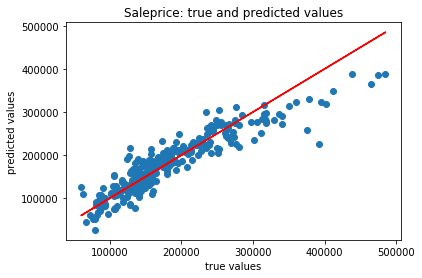

Mean absolute error of the prediction is: 22111.89518808321
Mean squared error of the prediction is: 940630411.9529938
Root mean squared error of the prediction is: 30669.69859573116
Mean absolute percentage error of the prediction is: 13.022627749823815


In [5]:
# We add constant to the test set as it's a best practice to do so:
X_test = sm.add_constant(X_test)

# Making prediction on the test set:
y_preds = result.predict(X_test)

# Visualize the true values and predicted values:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Saleprice: true and predicted values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Looking at the graph above, it seems that our houseprice model is better at predicting cheaper properties than those more expensive ones on the right end of the chart.